In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00


### 1. Load the required libraries

In [2]:
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [3]:
# 데이터 불러오기
df_train = pd.read_csv('complete_train.csv')
df_test = pd.read_csv('complete_test.csv')

### 2. Preprocessing data

In [4]:
df_train['text'] = df_train['title'] + ' ' + df_train['content']
df_test['text'] = df_test['title'] + ' ' + df_test['content']

# NaN 값을 포함하는 행 삭제
df_train.dropna(subset=['text'], inplace=True)

In [5]:
# 원본 데이터를 학습 데이터와 테스트 데이터로 나눔
train_df, val_df = train_test_split(df_train, test_size=500, random_state=42)

In [6]:
# KoBERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

In [7]:
def encode_data(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 직접 패딩 수행
        padding_length = max_len - len(encoded_dict['input_ids'][0])
        all_tokens.append(torch.cat([encoded_dict['input_ids'], torch.zeros((1, padding_length), dtype=torch.long)], dim=1))
        all_masks.append(torch.cat([encoded_dict['attention_mask'], torch.zeros((1, padding_length), dtype=torch.long)], dim=1))

    all_tokens = torch.cat(all_tokens, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    return all_tokens, all_masks


In [8]:
# 학습 데이터 인코딩
train_input_ids, train_attention_masks = encode_data(train_df['text'], tokenizer)
train_labels1 = torch.tensor(train_df['label1'].values) - 1
train_labels2 = torch.tensor(train_df['label2'].values)

# 테스트 데이터 인코딩 및 성능 평가
val_input_ids, val_attention_masks = encode_data(val_df['text'], tokenizer)
val_labels1 = torch.tensor(val_df['label1'].values) - 1
val_labels2 = torch.tensor(val_df['label2'].values)

In [9]:
# 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels1, train_labels2)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels1, val_labels2)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

label1 counts:
1     358
2     748
3    1931
4    1253
5     210
Name: label1, dtype: int64

label2 counts:
0    1832
1     408
2     478
3     890
4     681
5     211
Name: label2, dtype: int64


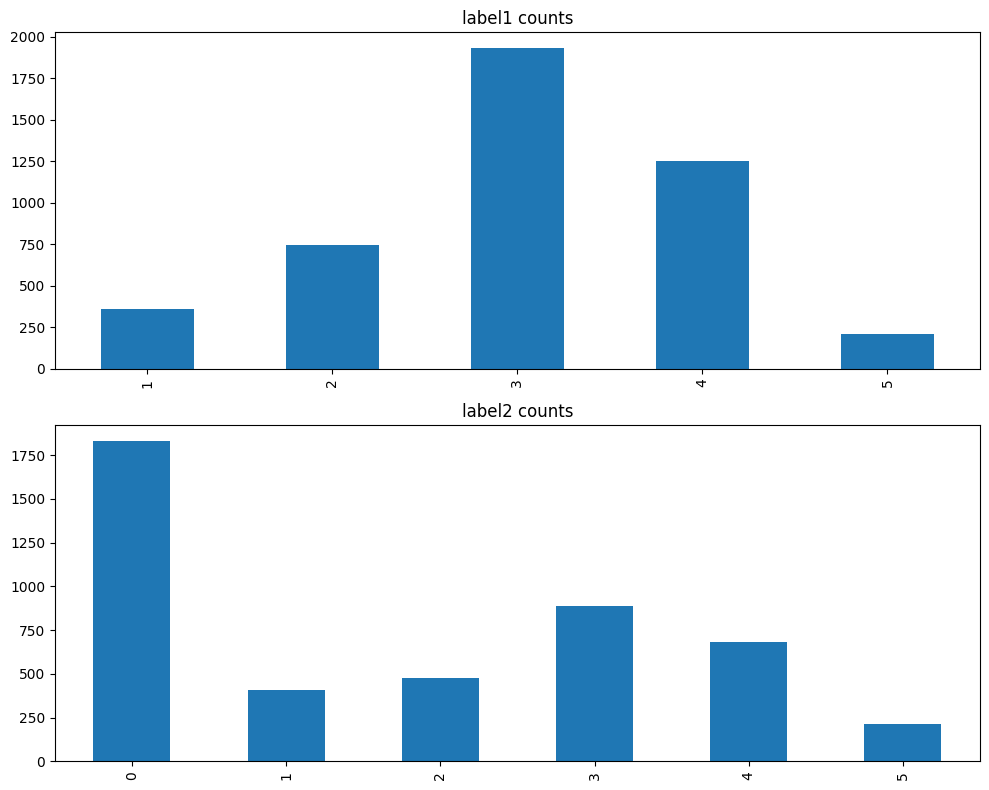

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# label1, label2 열의 값들이 몇 개씩 있는지 확인 후 오름차순 정렬
label1_counts = df_train['label1'].value_counts().sort_index()
label2_counts = df_train['label2'].value_counts().sort_index()

# 결과 출력
print("label1 counts:")
print(label1_counts)
print("\nlabel2 counts:")
print(label2_counts)

# 그래프로 나타내기
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

label1_counts.plot(kind='bar', ax=ax[0], title='label1 counts')
label2_counts.plot(kind='bar', ax=ax[1], title='label2 counts')

plt.tight_layout()
plt.show()

In [11]:
# 모델 정의
class KoBERTForMultiLabelSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels1, num_labels2):
        super(KoBERTForMultiLabelSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('monologg/kobert')
        self.classifier1 = torch.nn.Linear(768, num_labels1)
        self.classifier2 = torch.nn.Linear(768, num_labels2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # CLS 토큰의 히든 상태
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        return logits1, logits2



# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels1 = df_train['label1'].nunique()
num_labels2 = df_train['label2'].nunique()
model = KoBERTForMultiLabelSequenceClassification(num_labels1, num_labels2).to(device)
optimizer = Adam(model.parameters(), lr=1e-5)


loss_fn1 = CrossEntropyLoss()
loss_fn2 = CrossEntropyLoss()

In [12]:
from tqdm import tqdm
from sklearn.metrics import f1_score

EPOCHS = 20

train_losses = []
val_losses = []
val_accuracies1 = []
val_accuracies2 = []
val_f1_scores1 = []
val_f1_scores2 = []
best_model_path = "best_model.pth"

best_score1 = 0
best_score2 = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct1 = 0
    total_correct2 = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        input_ids, attention_mask, label1, label2 = [b.to(device) for b in batch]
        logits1, logits2 = model(input_ids, attention_mask)

        loss1 = loss_fn1(logits1, label1)
        loss2 = loss_fn2(logits2, label2)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct1 += (logits1.argmax(dim=1) == label1).sum().item()
        total_correct2 += (logits2.argmax(dim=1) == label2).sum().item()
        total_samples += label1.size(0)

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    # Evaluate on valid set
    model.eval()
    val_loss = 0
    val_correct1 = 0
    val_correct2 = 0
    val_samples = 0
    val_preds1 = []
    val_preds2 = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, label1, label2 = [b.to(device) for b in batch]
            logits1, logits2 = model(input_ids, attention_mask)

            loss1 = loss_fn1(logits1, label1)
            loss2 = loss_fn2(logits2, label2)
            val_loss += (loss1 + loss2).item()

            val_correct1 += (logits1.argmax(dim=1) == label1).sum().item()
            val_correct2 += (logits2.argmax(dim=1) == label2).sum().item()
            val_samples += label1.size(0)

            val_preds1.extend(logits1.argmax(dim=1).tolist())
            val_preds2.extend(logits2.argmax(dim=1).tolist())

    avg_val_loss = val_loss / val_samples
    val_losses.append(avg_val_loss)
    val_accuracy1 = val_correct1 / val_samples
    val_accuracy2 = val_correct2 / val_samples
    val_accuracies1.append(val_accuracy1)
    val_accuracies2.append(val_accuracy2)
    f1_1 = f1_score(val_labels1.cpu(), val_preds1, average='weighted')
    f1_2 = f1_score(val_labels2.cpu(), val_preds2, average='weighted')
    val_f1_scores1.append(f1_1)
    val_f1_scores2.append(f1_2)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy1: {val_accuracy1:.4f}")
    print(f"Validation Accuracy2: {val_accuracy2:.4f}")
    print(f"Validation F1 Score for Label1: {f1_1:.4f}")
    print(f"Validation F1 Score for Label2: {f1_2:.4f}\n")

    # 최고 정확도를 갱신할 경우 모델 저장
    if val_accuracy1 > best_score1 and val_accuracy2 > best_score2:
        best_score1, best_score2 = val_accuracy1, val_accuracy2
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved for epoch {epoch+1} with accuracy1: {best_score1:.4f} and accuracy2: {best_score2:.4f}\n")


Training Epoch 1/20: 100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s]



Epoch 1/20
Train Loss: 0.7210
Validation Loss: 1.3870
Validation Accuracy1: 0.4680
Validation Accuracy2: 0.4260
Validation F1 Score for Label1: 0.3965
Validation F1 Score for Label2: 0.2545

Model saved for epoch 1 with accuracy1: 0.4680 and accuracy2: 0.4260



Training Epoch 2/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]



Epoch 2/20
Train Loss: 0.6815
Validation Loss: 1.3138
Validation Accuracy1: 0.4760
Validation Accuracy2: 0.4780
Validation F1 Score for Label1: 0.4230
Validation F1 Score for Label2: 0.3976

Model saved for epoch 2 with accuracy1: 0.4760 and accuracy2: 0.4780



Training Epoch 3/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]



Epoch 3/20
Train Loss: 0.6447
Validation Loss: 1.2635
Validation Accuracy1: 0.4820
Validation Accuracy2: 0.4980
Validation F1 Score for Label1: 0.4219
Validation F1 Score for Label2: 0.4081

Model saved for epoch 3 with accuracy1: 0.4820 and accuracy2: 0.4980



Training Epoch 4/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.91it/s]



Epoch 4/20
Train Loss: 0.6095
Validation Loss: 1.2500
Validation Accuracy1: 0.4860
Validation Accuracy2: 0.5080
Validation F1 Score for Label1: 0.4803
Validation F1 Score for Label2: 0.4669

Model saved for epoch 4 with accuracy1: 0.4860 and accuracy2: 0.5080



Training Epoch 5/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]



Epoch 5/20
Train Loss: 0.5770
Validation Loss: 1.2094
Validation Accuracy1: 0.4980
Validation Accuracy2: 0.5080
Validation F1 Score for Label1: 0.4933
Validation F1 Score for Label2: 0.4742



Training Epoch 6/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]



Epoch 6/20
Train Loss: 0.5373
Validation Loss: 1.2229
Validation Accuracy1: 0.4980
Validation Accuracy2: 0.5300
Validation F1 Score for Label1: 0.4919
Validation F1 Score for Label2: 0.4810

Model saved for epoch 6 with accuracy1: 0.4980 and accuracy2: 0.5300



Training Epoch 7/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]



Epoch 7/20
Train Loss: 0.4903
Validation Loss: 1.2435
Validation Accuracy1: 0.5360
Validation Accuracy2: 0.5280
Validation F1 Score for Label1: 0.5186
Validation F1 Score for Label2: 0.5125



Training Epoch 8/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]



Epoch 8/20
Train Loss: 0.4434
Validation Loss: 1.2625
Validation Accuracy1: 0.4860
Validation Accuracy2: 0.5280
Validation F1 Score for Label1: 0.4869
Validation F1 Score for Label2: 0.5182



Training Epoch 9/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.96it/s]



Epoch 9/20
Train Loss: 0.3846
Validation Loss: 1.3254
Validation Accuracy1: 0.5100
Validation Accuracy2: 0.5060
Validation F1 Score for Label1: 0.5034
Validation F1 Score for Label2: 0.5111



Training Epoch 10/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]



Epoch 10/20
Train Loss: 0.3205
Validation Loss: 1.4355
Validation Accuracy1: 0.5140
Validation Accuracy2: 0.5040
Validation F1 Score for Label1: 0.5121
Validation F1 Score for Label2: 0.5107



Training Epoch 11/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]



Epoch 11/20
Train Loss: 0.2681
Validation Loss: 1.5108
Validation Accuracy1: 0.5180
Validation Accuracy2: 0.5100
Validation F1 Score for Label1: 0.5079
Validation F1 Score for Label2: 0.5121



Training Epoch 12/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]



Epoch 12/20
Train Loss: 0.2204
Validation Loss: 1.5461
Validation Accuracy1: 0.5140
Validation Accuracy2: 0.5420
Validation F1 Score for Label1: 0.5124
Validation F1 Score for Label2: 0.5351

Model saved for epoch 12 with accuracy1: 0.5140 and accuracy2: 0.5420



Training Epoch 13/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]



Epoch 13/20
Train Loss: 0.1733
Validation Loss: 1.7460
Validation Accuracy1: 0.5100
Validation Accuracy2: 0.5120
Validation F1 Score for Label1: 0.5091
Validation F1 Score for Label2: 0.5191



Training Epoch 14/20: 100%|██████████| 1000/1000 [01:41<00:00,  9.90it/s]



Epoch 14/20
Train Loss: 0.1477
Validation Loss: 1.8401
Validation Accuracy1: 0.4920
Validation Accuracy2: 0.5260
Validation F1 Score for Label1: 0.4991
Validation F1 Score for Label2: 0.5287



Training Epoch 15/20: 100%|██████████| 1000/1000 [01:41<00:00,  9.90it/s]



Epoch 15/20
Train Loss: 0.1237
Validation Loss: 1.8746
Validation Accuracy1: 0.5160
Validation Accuracy2: 0.5320
Validation F1 Score for Label1: 0.5141
Validation F1 Score for Label2: 0.5309



Training Epoch 16/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]



Epoch 16/20
Train Loss: 0.0967
Validation Loss: 2.0402
Validation Accuracy1: 0.5040
Validation Accuracy2: 0.5160
Validation F1 Score for Label1: 0.5087
Validation F1 Score for Label2: 0.5167



Training Epoch 17/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]



Epoch 17/20
Train Loss: 0.0791
Validation Loss: 2.1653
Validation Accuracy1: 0.4900
Validation Accuracy2: 0.5260
Validation F1 Score for Label1: 0.4950
Validation F1 Score for Label2: 0.5262



Training Epoch 18/20: 100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]



Epoch 18/20
Train Loss: 0.0732
Validation Loss: 2.1435
Validation Accuracy1: 0.5080
Validation Accuracy2: 0.5580
Validation F1 Score for Label1: 0.5107
Validation F1 Score for Label2: 0.5479



Training Epoch 19/20: 100%|██████████| 1000/1000 [01:39<00:00, 10.04it/s]



Epoch 19/20
Train Loss: 0.0558
Validation Loss: 2.3490
Validation Accuracy1: 0.4840
Validation Accuracy2: 0.5160
Validation F1 Score for Label1: 0.4840
Validation F1 Score for Label2: 0.5124



Training Epoch 20/20: 100%|██████████| 1000/1000 [01:41<00:00,  9.89it/s]



Epoch 20/20
Train Loss: 0.0542
Validation Loss: 2.3824
Validation Accuracy1: 0.5060
Validation Accuracy2: 0.5320
Validation F1 Score for Label1: 0.5012
Validation F1 Score for Label2: 0.5372



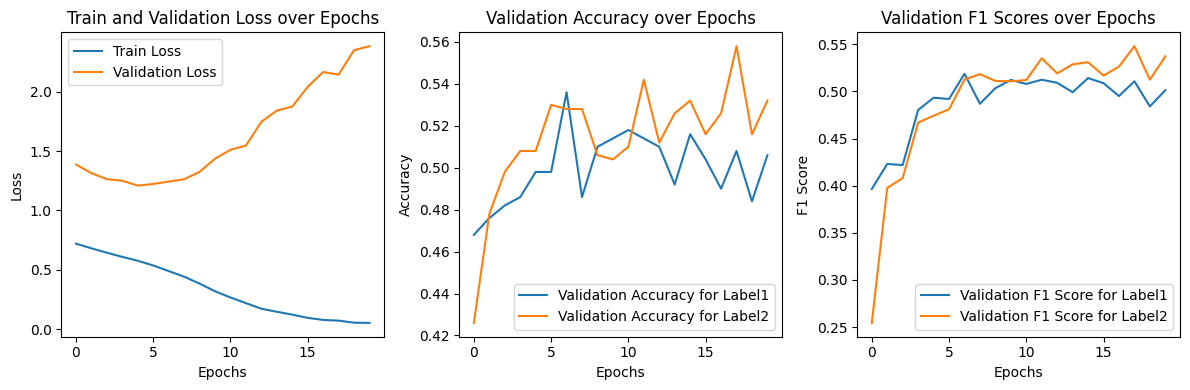

In [13]:
import matplotlib.pyplot as plt

# Plotting Train and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(EPOCHS), train_losses, label="Train Loss")
plt.plot(range(EPOCHS), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss over Epochs")
plt.legend()

# Plotting Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(EPOCHS), val_accuracies1, label="Validation Accuracy for Label1")
plt.plot(range(EPOCHS), val_accuracies2, label="Validation Accuracy for Label2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

# Plotting Validation F1 Score
plt.subplot(1, 3, 3)
plt.plot(range(EPOCHS), val_f1_scores1, label="Validation F1 Score for Label1")
plt.plot(range(EPOCHS), val_f1_scores2, label="Validation F1 Score for Label2")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Validation F1 Scores over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


### Performance evaluation using test dataset

label1 counts:
1    100
2    100
3    100
4    100
5    100
Name: label1, dtype: int64

label2 counts:
0    203
1     77
2     53
3     63
4     54
5     50
Name: label2, dtype: int64


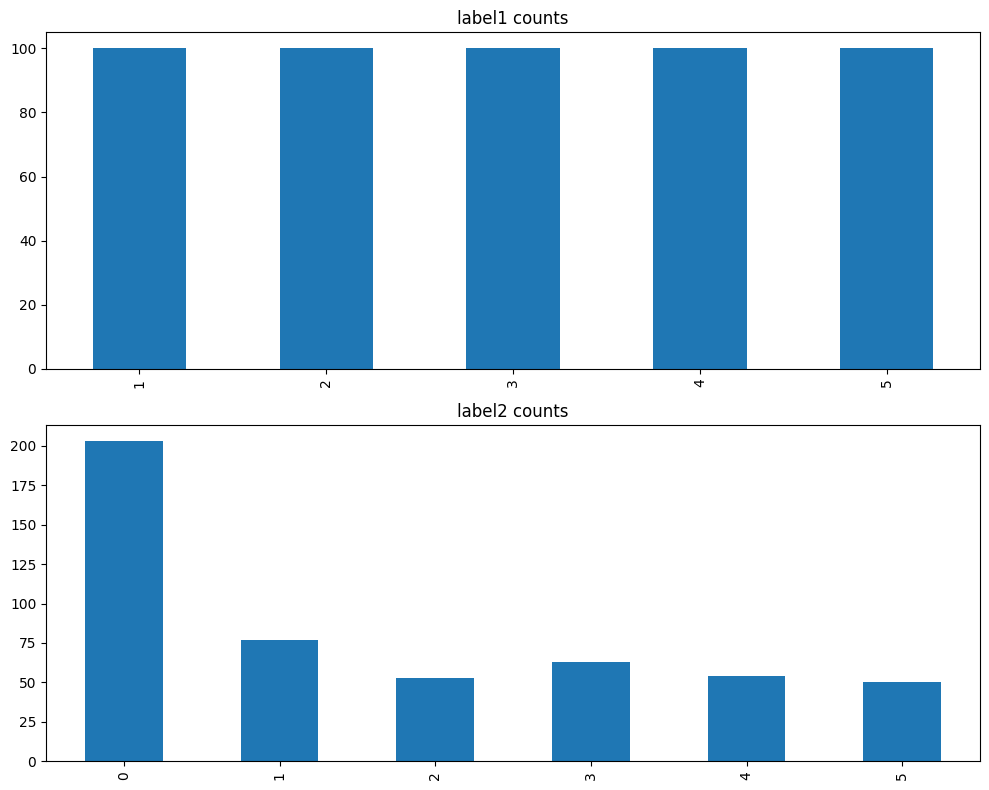

In [14]:
# label1, label2 열의 값들이 몇 개씩 있는지 확인 후 오름차순 정렬
label1_counts = df_test['label1'].value_counts().sort_index()
label2_counts = df_test['label2'].value_counts().sort_index()

# 결과 출력
print("label1 counts:")
print(label1_counts)
print("\nlabel2 counts:")
print(label2_counts)

# 그래프로 나타내기
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

label1_counts.plot(kind='bar', ax=ax[0], title='label1 counts')
label2_counts.plot(kind='bar', ax=ax[1], title='label2 counts')

plt.tight_layout()
plt.show()

In [15]:
# 학습 데이터 인코딩
test_input_ids, test_attention_masks = encode_data(df_test['text'], tokenizer)
test_labels1 = torch.tensor(df_test['label1'].values) - 1
test_labels2 = torch.tensor(df_test['label2'].values)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels1, test_labels2)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [16]:
# 학습이 끝난 후 가장 좋은 성능을 보인 모델을 불러옵니다.
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Top-2 정확도 계산
all_logits1 = []
all_logits2 = []
true_labels1 = []
true_labels2 = []
predicted_labels1 = []
predicted_labels2 = []

def topk_accuracy(true_labels, logits_list, k=2):
    """
    true_labels와 logits_list를 비교하여, top-k 예측 중에 정답이 있으면 맞게 평가한다.
    """
    correct = 0
    for label, logits in zip(true_labels, logits_list):
        topk_preds = torch.topk(logits, k=k).indices.tolist()
        if label in topk_preds:
            correct += 1
    return correct / len(true_labels)

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, label1, label2 = [b.to(device) for b in batch]
        logits1, logits2 = model(input_ids, attention_mask)

        true_labels1.extend(label1.tolist())
        true_labels2.extend(label2.tolist())
        predicted_labels1.extend(logits1.argmax(dim=1).tolist())
        predicted_labels2.extend(logits2.argmax(dim=1).tolist())

        all_logits1.extend(logits1)
        all_logits2.extend(logits2)

    top2_acc1 = topk_accuracy(true_labels1, all_logits1, k=2)
    top2_acc2 = topk_accuracy(true_labels2, all_logits2, k=2)

# 정확도 계산
accuracy1 = sum([1 if true == pred else 0 for true, pred in zip(true_labels1, predicted_labels1)]) / len(true_labels1)
accuracy2 = sum([1 if true == pred else 0 for true, pred in zip(true_labels2, predicted_labels2)]) / len(true_labels2)

# 결과 출력
print(f"Test Accuracy for Label1: {accuracy1:.4f}")
print(f"Test Accuracy for Label2: {accuracy2:.4f}")
print(f"Top-2 Test Accuracy for Label1: {top2_acc1:.4f}")
print(f"Top-2 Test Accuracy for Label2: {top2_acc2:.4f}")
print(f"F1 Score for Label1: {f1_1:.4f}")
print(f"F1 Score for Label2: {f1_2:.4f}")


Test Accuracy for Label1: 0.3960
Test Accuracy for Label2: 0.5240
Top-2 Test Accuracy for Label1: 0.6460
Top-2 Test Accuracy for Label2: 0.7020
F1 Score for Label1: 0.5012
F1 Score for Label2: 0.5372


In [17]:
print("\nTrue vs Predicted Labels:")
for true1, pred1, true2, pred2 in zip(true_labels1, predicted_labels1, true_labels2, predicted_labels2):
    print(f"Label1 - True: {true1 + 1}, Predicted: {pred1 + 1} | Label2 - True: {true2}, Predicted: {pred2}")



True vs Predicted Labels:
Label1 - True: 1, Predicted: 1 | Label2 - True: 1, Predicted: 1
Label1 - True: 1, Predicted: 3 | Label2 - True: 0, Predicted: 0
Label1 - True: 1, Predicted: 1 | Label2 - True: 1, Predicted: 1
Label1 - True: 1, Predicted: 2 | Label2 - True: 1, Predicted: 2
Label1 - True: 1, Predicted: 2 | Label2 - True: 1, Predicted: 0
Label1 - True: 1, Predicted: 2 | Label2 - True: 1, Predicted: 2
Label1 - True: 1, Predicted: 4 | Label2 - True: 1, Predicted: 2
Label1 - True: 1, Predicted: 2 | Label2 - True: 2, Predicted: 2
Label1 - True: 1, Predicted: 2 | Label2 - True: 1, Predicted: 2
Label1 - True: 1, Predicted: 5 | Label2 - True: 0, Predicted: 2
Label1 - True: 1, Predicted: 2 | Label2 - True: 1, Predicted: 2
Label1 - True: 1, Predicted: 3 | Label2 - True: 1, Predicted: 3
Label1 - True: 1, Predicted: 3 | Label2 - True: 1, Predicted: 0
Label1 - True: 1, Predicted: 1 | Label2 - True: 1, Predicted: 1
Label1 - True: 1, Predicted: 1 | Label2 - True: 1, Predicted: 1
Label1 - True